In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split,\
      LearningCurveDisplay, learning_curve
from sklearn.compose import make_column_transformer

import mlrose_hiive as mlrose
from mlrose_hiive import MaxKColorGenerator, QueensGenerator, FlipFlopGenerator,\
      TSPGenerator, KnapsackGenerator, ContinuousPeaksGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner, MIMICRunner, RHCRunner
# from mlrose_hiive import SKMLPRunner

## Data Pre-processing

In [3]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test = train_test_split(
    x_shroom, y_shroom, test_size=0.2)


In [4]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

In [5]:
train_size = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()

nn = mlrose.NeuralNetwork(hidden_nodes = [100],
                                activation = 'relu',
                                algorithm = 'simulated_annealing',
                                max_iters = 10,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 5,
                                max_attempts =100,
                                curve=False,
                                random_state = 123456)

train_sizes_sa, train_scores_sa, test_scores_sa, fit_times_sa, score_times_sa = learning_curve(
    nn, X=x_shroom.to_numpy(), y=y_shroom.to_numpy(), cv=cv,
    train_sizes=[0.3, 0.6, 0.9], return_times=True, random_state=123456,
    # scoring='precision',
)

test_scores_sa

array([[0.42285714, 0.47857143, 0.44142857, 0.41428571, 0.46857143,
        0.41285714, 0.44714286, 0.42857143, 0.46428571, 0.48285714],
       [0.42285714, 0.47857143, 0.44142857, 0.41428571, 0.46857143,
        0.41285714, 0.44714286, 0.42857143, 0.46428571, 0.48285714],
       [0.42285714, 0.47857143, 0.44142857, 0.41428571, 0.46857143,
        0.41285714, 0.44714286, 0.42857143, 0.46428571, 0.48285714]])

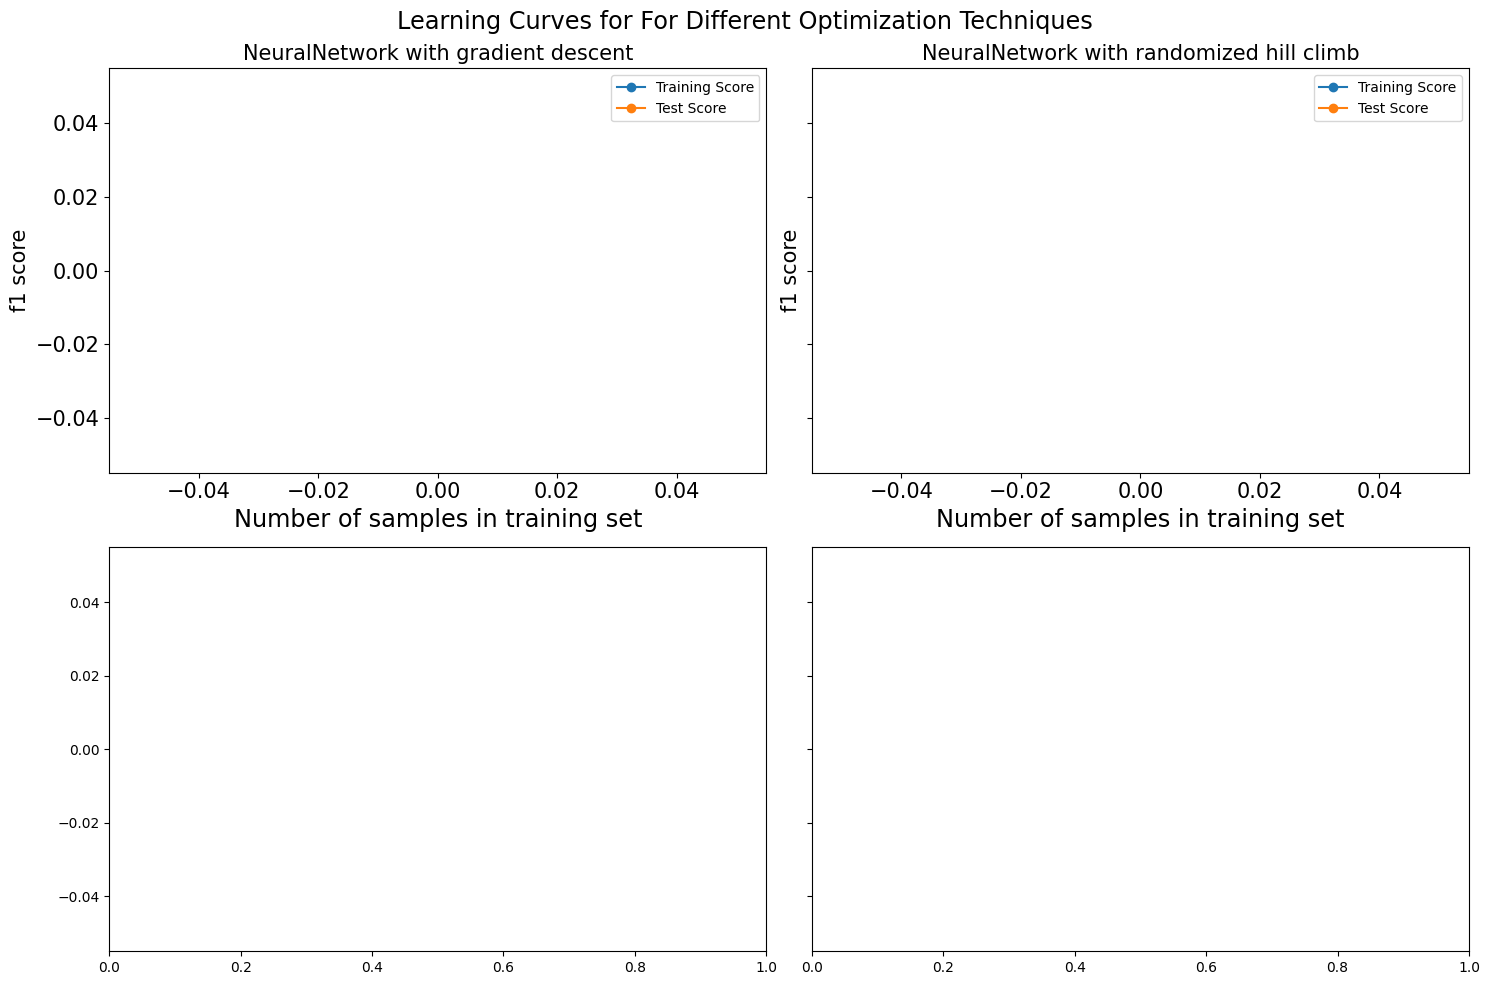

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import make_scorer
train_size = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()

nn_gd = mlrose.NeuralNetwork(hidden_nodes = [100],
                                activation = 'relu',
                                algorithm = 'gradient_descent',
                                max_iters = 100,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 5,
                                max_attempts =100,
                                curve=False,
                                random_state = 123456)

nn_ga = mlrose.NeuralNetwork(hidden_nodes = [100],
                                activation = 'relu',
                                algorithm = 'genetic_alg',
                                max_iters = 100,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 5,
                                max_attempts =100,
                                curve=False,
                                random_state = 123456)

nn_sa = mlrose.NeuralNetwork(hidden_nodes = [100],
                                activation = 'relu',
                                algorithm = 'simulated_annealing',
                                max_iters = 100,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 5,
                                max_attempts =100,
                                curve=False,
                                random_state = 123456)

nn_rhc = mlrose.NeuralNetwork(hidden_nodes = [100],
                                activation = 'relu',
                                algorithm = 'random_hill_climb',
                                max_iters = 100,
                                bias = True,
                                is_classifier = True,
                                learning_rate = 0.001,
                                early_stopping = True,
                                clip_max = 5,
                                max_attempts =100,
                                curve=False,
                                random_state = 123456)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
ax = ax.flatten()
# fig.delaxes(ax[4])
# fig.delaxes(ax[5])

common_params = {
    "X": x_shroom,
    "y": y_shroom,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    # "score_name":make_scorer(accuracy_score),
    "score_type": "both",
    "n_jobs": -1,
}
#  nn_ga, nn_sa
name_lst = ['gradient descent', 'randomized hill climb', 'genetic algorithm', 'simulated annealing']
for ax_idx, estimator in enumerate([nn_gd, nn_rhc,]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{estimator.__class__.__name__} with {name_lst[ax_idx]}", fontsize=15)
    ax[ax_idx].set_xlabel('Number of samples in training set', fontsize='xx-large')
    ax[ax_idx].set_ylabel('f1 score',fontsize = 15)
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)
fig.suptitle('Learning Curves for For Different Optimization Techniques', fontsize='xx-large')
plt.tight_layout()

In [ ]:
train_sizes_ga, train_scores_ga, test_scores_ga, fit_times_ga, score_times_ga = learning_curve(
    nn_sa, x_shroom, y_shroom, cv=5, n_jobs=-1, scoring='f1', train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

train_sizes_ga, train_scores_ga, test_scores_ga, fit_times_ga, score_times_ga = learning_curve(
    nn_ga, x_shroom, y_shroom, cv=5, n_jobs=-1, scoring='f1', train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

train_sizes_rhc, train_scores_rhc, test_scores_rhc, fit_times_rhc, score_times_rhc = learning_curve(
    nn_rhc, x_shroom, y_shroom, cv=5, n_jobs=-1, scoring='f1', train_sizes=np.linspace(0.05, 1.0, 10),
      return_times=True, random_state=123456
)

train_sizes_gd, train_scores_gd, test_scores_gd, fit_times_gd, score_times_gd = learning_curve(
    nn_gd, x_shroom, y_shroom, cv=5, n_jobs=-1, scoring='f1', train_sizes=np.linspace(0.05, 1.0, 10), return_times=True, random_state=123456
)

## Neural Network

In [ ]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    'max_iters': [100],                     # nn params
    'learning_rate': [0.0001],                         # nn params
    'schedule': [mlrose.ArithDecay(100)],  # sa params
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='nn_test',
                    algorithm=mlrose.algorithms.sa.simulated_annealing,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100],
                    hidden_layer_sizes=[[100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df, curves_df, cv_results_df, sr = nnr.run()          # GridSearchCV instance returned   

In [ ]:
sr.best_estimator_

In [ ]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    'max_iters': [150],                     # nn params
    'learning_rate': [0.0001, 0.001, 0.01],                         # nn params
    'schedule': [mlrose.ArithDecay(20), mlrose.ArithDecay(40), mlrose.ArithDecay(60)]
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='nn_test',
                    algorithm=mlrose.algorithms.sa.simulated_annealing,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100, 500, 1000],
                    hidden_layer_sizes=[[10], [50], [100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df, curves_df, cv_results_df, sr = nnr.run()          # GridSearchCV instance returned   

In [ ]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    'max_iters': [1],
    'learning_rate': [0.0001],
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='nn_test',
                    algorithm=mlrose.algorithms.ga.genetic_alg,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100],
                    hidden_layer_sizes=[[100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df, curves_df, cv_results_df, sr = nnr.run() 

In [ ]:
grid_search_parameters = ({
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
    'max_iters': [150],
    'learning_rate': [0.0001],
})

nnr = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name='nn_test',
                    algorithm=mlrose.algorithms.rhc.random_hill_climb,
                    grid_search_parameters=grid_search_parameters,
                    iteration_list=[100],
                    hidden_layer_sizes=[[100]],
                    bias=True,
                    early_stopping=False,
                    clip_max=1e+10,
                    max_attempts=500,
                    generate_curves=True,
                    seed=123456)

run_stats_df, curves_df, cv_results_df, sr = nnr.run()          # GridSearchCV instance returned   

In [ ]:
# Tune max_iters and learning_rate_init
grid_search = {
    "max_iters": [5000, 10000, 25000, 50000],
    "learning_rate_init": [0.001, 0.1, 0.1, 0.5, 1],
    "activation": [mlrose.neural.activation.relu],
    "is_classifier": [True],
}

runner = NNGSRunner(x_train=x_shroom_train,
                    y_train=y_shroom_train,
                    x_test=x_shroom_test,
                    y_test=y_shroom_test,
                    experiment_name="full_grid_search",
                    algorithm=mlrose.algorithms.gradient_descent,
                    grid_search_parameters=grid_search,
                    iteration_list = [1000, 2500, 5000, 10000],
                    hidden_layer_sizes=[[6,6]],
                    bias=True,
                    early_stopping=True,
                    clip_max=1,
                    max_attempts=1000,
                    generate_curves=True,
                    seed=123456,
                    n_jobs=-1
                          )
run_stats, curves, cv_results, best_est = runner.run()

## Define Fitness Functions

### N-Queens

In [ ]:
fitness = mlrose.Queens()
four_fitness = mlrose.FourPeaks()
weights = [10, 5, 2, 8, 15, 13, 18, 25]
values = list(np.arange(1, 9))
max_weight_pct = 0.5
knap_fitness = mlrose.Knapsack(weights, values, max_weight_pct)

In [ ]:
problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = fitness, 
    maximize = False, max_val = 8
    )

four_problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = four_fitness, 
    maximize = False, max_val = 2
    )

knap_problem = mlrose.DiscreteOpt(
    length = 8, fitness_fn = knap_fitness, 
    maximize = False, max_val = 8
    )

In [ ]:
import numpy as np
weights = [10, 5, 2, 8, 15]
values = [1, 2, 3, 4, 5]
max_weight_pct = 0.6
fitness = mlrose.Knapsack(weights, values, max_weight_pct)
state = np.array([1, 0, 2, 1, 0])
fitness.evaluate(state)

In [ ]:
# a function to run an N-queens problem using
# define a fitness function

In [ ]:
# Define decay schedule
schedule = mlrose.ExpDecay()

# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using simulated annealing
best_state, best_fitness, curve = mlrose.simulated_annealing(
    four_problem, schedule = schedule,
    max_attempts = 10, max_iters = 1000,
    init_state = init_state, random_state = 123321,
    curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# Solve problem using MIMIC
best_state, best_fitness, curve = mlrose.mimic(
    four_problem, max_attempts = 10, max_iters = 1000,
    random_state = 123321, curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# create a runner class and solve the problem
sa_run = SARunner(problem=four_problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
              decay_list=[mlrose.GeomDecay])

# the two data frames will contain the results
df_run_stats, df_run_curves = sa_run.run()

In [ ]:
df_run_curves

In [ ]:
# create a runner class and solve the problem
mimic_run = MIMICRunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes = [200],
              keep_percent_list = [0.25, 0.5, 0.75]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = mimic_run.run()

In [ ]:
df_run_curves

In [ ]:
sa_run.runner_name()

In [ ]:
# create a runner class and solve the problem
ga_run = GARunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes = [200],
              mutation_rates = [0.25, 0.5, 0.75]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = ga_run.run()

In [ ]:
df_run_curves

In [ ]:
# create a runner class and solve the problem
rhc_run = RHCRunner(problem=problem,
              experiment_name='queens8_sa',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              restart_list=[25, 75, 100]
              )

# the two data frames will contain the results
df_run_stats, df_run_curves = rhc_run.run()

In [ ]:
df_run_curves[(df_run_curves['Fitness']==0) & (df_run_curves['Iteration']<20)]

In [ ]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using simulated annealing
best_state, best_fitness, curve = mlrose.random_hill_climb(
    problem, max_attempts = 10, max_iters = 1000,
    init_state = init_state, random_state = 123321,
    curve=True
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using genetic algorithms
best_state, best_fitness, curve = mlrose.genetic_alg(
    problem, pop_size=200, mutation_prob=0.1, max_attempts=10, 
    max_iters=1000, curve=True, random_state=123321
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

In [ ]:
# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Solve problem using MIMIC
best_state, best_fitness, curve = mlrose.mimic(
    problem, pop_size=50, keep_pct=0.01, max_attempts=10,
    max_iters=100, curve=True, random_state=123321
    )

print(best_state)
print(best_fitness)
fig, ax = plt.subplots()
ax.plot(curve[:,1], curve[:,0])
plt.show()

### Neural Network

In [ ]:
nn = mlrose.NeuralNetwork(hidden_nodes = [], activation = 'sigmoid', 
                                    algorithm = 'random_hill_climb', 
                                    max_iters = 1000, bias = True, is_classifier = True, 
                                    learning_rate = 0.01, early_stopping = True, 
                                    clip_max = 5, max_attempts = 100, random_state = 3)

In [ ]:
nn_params = {
    'activation': 'relu', 'hidden_layer_sizes': (100,), 
    'learning_rate': 'constant', 'learning_rate_init': 0.01, 
    'solver': 'sgd'
    }